<a href="https://colab.research.google.com/github/kabashiy/mysite/blob/master/1_bitCSreplica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-bit 圧縮センシングのレプリカ計算
**問題設定** \
真の信号生成モデル
$$\boldsymbol{s}^0 \sim \prod_{i=1}^N [(1-f)\delta(s_i^0) + \frac{f}{2}
\left (\delta(s^0-1) + \delta(s^0+1) \right ) ]$$
観測行列　\
$$ A_{\mu k} \sim \mathcal N(0, \rho^k/N) $$
観測過程 \
$$ b_\mu = \sum_{k=1}^N A_{\mu k} s_k^0 $$
$$ y_\mu \in \{+1,-1\}\sim P(y_\mu | b_\mu) = \Theta(y_\mu b_\mu) $$
復元過程 \
$$ \hat{\boldsymbol{s}} = \mathop{\rm argmin}_{\boldsymbol{s}} \left \{ ||\boldsymbol{s} ||_1 \right \} \quad {\rm subj. to} \quad y_\mu (b_\mu -\kappa) > 0 \quad \mu=1,2,\ldots, M $$



In [45]:
# 必要なライブラリの読み込み
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import erfc 
from numpy import sqrt, sin, cos, pi, exp

# System parameters
Nsamp = int(1e6)
N = 100
alpha = 4
M = int(alpha*N)
kappa = 0.2
f = 0.1
sigS2 = 1
rho = exp(-1./M)

kMAX = N



In [38]:
# Definition of basic functions 
def H(x):
    return 0.5*erfc(x/sqrt(2))

def G(x):
    return exp(-x**2/2)/sqrt(2*pi)

def P0(y,z,T,m,q,kappa):
    arg = y*(m/sqrt(q)*z-kappa)/sqrt(T-m**2/q)
    return H(-arg)

def DP0(y,z,T,m,q,kappa):
    arg = y*(m/sqrt(q)*z-kappa)/sqrt(T-m**2/q)
    return G(arg)/sqrt(T-m**2/q)

def ReLU(x):
    return x*(x>0)

def Efunc(z,T,m,q,kappa):
    return G(z)*(P0(+1, z, T,m,q,kappa)*(-(sqrt(q)*z-kappa)>0)+P0(-1,z,T,m,q,kappa)*((sqrt(q)*z-kappa) > 0))

def Ffunc(z,T,m,q,kappa):
    return G(z)*(P0(+1,z,T,m,q,kappa)*(ReLU(-(sqrt(q)*z-kappa)))**2+P0(-1,z,T,m,q,kappa)*(ReLU(sqrt(q)*z-kappa))**2)

def Kfunc(z,T,m,q,kappa):
    return  G(z)*(DP0(+1,z,T,m,q,kappa)*ReLU(sqrt(q)*z-kappa)+DP0(-1,z,T,m,q,kappa)*ReLU(-(sqrt(q)*z-kappa)))

def Shfunc(a, b):
    return (b-np.sign(b))*(np.abs(b) > 1)/a

 

In [50]:
# Initialization 
S0 = np.zeros(Nsamp)
S0[:int(f*Nsamp/2)] = np.ones(int(f*Nsamp/2))
S0[int(f*Nsamp/2):int(f*Nsamp)] = -np.ones(int(f*Nsamp/2))

T = (S0**2).mean()
print('T = {}'.format(T))
v = np.random.randn(Nsamp)

chi = 1
q = 0.5*sigS2
m = 0

EPS = 1.0e-6
Niter = 1000
gamma = .5


q_list = q*np.ones(kMAX)
chi_list = chi*np.ones(kMAX)
m_list = m*np.ones(kMAX) 


ERR = 100
iter = 0 
while ERR > EPS and iter < Niter:
    iter += 1
    # Recode of previous step
    kq = q
    kchi = chi
    km = m
    
    # Integrals for (chi, q, m) -> (E,F,K)
    IE, IEerr = quad(lambda z: Efunc(z, T, m, q, kappa), -10,10)
    E = alpha/chi*IE
    IF, IFerr = quad(lambda z: Ffunc(z, T, m, q, kappa), -10,10)
    F = alpha/chi**2*IF
    IK, IKerr = quad(lambda z: Kfunc(z, T, m, q, kappa),-10,10)
    K = alpha/chi*IK

    # Integrals for (E,F,K) -> (chi, q, m)
    for k in range(kMAX):
        h = rho**k*K*S0 + sqrt(rho**k*F)*v
        Sh = Shfunc(rho**k*E, h)
    
        q_list[k] = rho**k*(Sh**2).mean()
        chi_list[k] = rho**k/(rho**k*E)*(np.abs(h) > 1).mean()
        m_list[k] = rho**k*(S0*Sh).mean()

    q = (1-gamma)*kq + gamma*q_list.mean()
    chi = (1-gamma)*kchi + gamma*chi_list.mean()
    m = (1-gamma)*km + gamma*m_list.mean()
        
    ERR = np.abs(kq-q) + np.abs(kchi-chi) + np.abs(km-m)

        # print("iter = {} ERR = {} E = {} F = {} K = {}".format(iter, ERR,E,F,K))
    print("iter = {} ERR = {} q = {} chi = {} m = {}".format(iter, ERR, q, chi, m))



T = 0.1
iter = 1 ERR = 0.6451960085435114 q = 0.2992933851205393 chi = 0.5885552236483996 m = 0.033044617312450474
iter = 2 ERR = 0.34490286183604446 q = 0.1936280038935655 chi = 0.3664048100933632 m = 0.05013168436648467
iter = 3 ERR = 0.19103105929801037 q = 0.13522281100728786 chi = 0.24189308448182334 m = 0.05824582516667758
iter = 4 ERR = 0.10928570963880888 q = 0.10153041947175181 chi = 0.1696816772718194 m = 0.06162773605994648
iter = 5 ERR = 0.06429058454044576 q = 0.08149930190355906 chi = 0.1265269186946794 m = 0.06273244445505949
iter = 6 ERR = 0.03871001661800659 q = 0.0694108248564476 chi = 0.10006062210288971 m = 0.06288768743416492
iter = 7 ERR = 0.024032538304869802 q = 0.062113121347443664 chi = 0.08346919364335342 m = 0.06274428109783535
iter = 8 ERR = 0.015106931973232804 q = 0.05776821893615061 chi = 0.07287147552469823 m = 0.06257996965455079
iter = 9 ERR = 0.009456768335234199 q = 0.05526742446618825 chi = 0.06600388127349882 m = 0.06249159004047836
iter = 10 ERR 

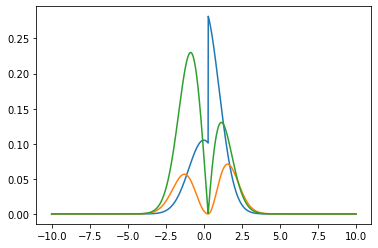

In [ ]:
z = np.array([i/100 for i in range(-1000,1001)])
plt.plot(z,Efunc(z,T,m,q,kappa), z, Ffunc(z,T,m,q,kappa), z, Kfunc(z,T,m,q,kappa))

In [ ]:
28900*12

346800